# Next Level
### Updating Vader Lexicon with External Lexicon:   
https://github.com/jasonyip184/StockSentimentTrading/blob/master/Stock%20Sentiment%20Algo%20Trading.ipynb  
https://towardsdatascience.com/https-towardsdatascience-com-algorithmic-trading-using-sentiment-analysis-on-news-articles-83db77966704  
https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists

In [256]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
#nltk.download('vader_lexicon')
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import csv,json
import pandas as pd
# mute the warnings
import warnings
warnings.filterwarnings("ignore")
import nltk.data
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from nltk import tokenize
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [65]:
# Reading the saved data pickle file
df_stocks = pd.read_pickle('data_raw/pickled_twenty_year_filtered_lead_para.pkl')

with open('Russell_2000.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    # Converting the csv file reader to a lists 
    data_list = list(spamreader)

# Separating header from the data
header = data_list[0] 
data_list = data_list[1:] 

data_list = np.asarray(data_list)

# Selecting date and close value for each day
selected_data = data_list[:, [0, 4, 5]]



df = pd.DataFrame(data=selected_data[0:,1:],
             index=selected_data[0:,0],
                                columns=['close', 'adj close'],
                                        dtype='float64')

# Reference for pandas interpolation http://pandas.pydata.org/pandas-docs/stable/missing_data.html
# Adding missing dates to the dataframe
df1 = df
idx = pd.date_range('01-03-2000', '12-30-2019')
df1.index = pd.DatetimeIndex(df1.index)
df1 = df1.reindex(idx, fill_value=np.NaN)

interpolated_df = df1.interpolate()
interpolated_df.count() 

# Removing extra date rows added in data for calculating interpolation
# interpolated_df = interpolated_df[3:]

df_stocks['prices'] = interpolated_df['close'].apply(np.int64)

#df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)

# selecting the prices and articles
df_stocks = df_stocks[['prices', 'articles']]

df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))

df_stocks.head()



,prices,articles
2000-01-03,496,Looking Back to Move Forward. A Touch of Spri...
2000-01-04,478,No Bones About It. Carroll and Rhodes Are Out...
2000-01-05,478,"Climate Control. With Mild Winter, Snow Busin..."
2000-01-06,475,"Calling All Units. Larry Bearnarth, 58, the B..."
2000-01-07,488,Nature in a Flick of the Eye. Defense Chief P...


In [66]:
df_stocks.to_csv('hhsample_interpolated_df_20_years_filtered_lead_para.csv',sep=',', encoding='utf-8')

In [67]:
df = df_stocks[['prices']].copy()
df.head()

,prices
2000-01-03,496
2000-01-04,478
2000-01-05,478
2000-01-06,475
2000-01-07,488


In [68]:
# Adding new columns to the data frame
df["compound"] = ''
df["neg"] = ''
df["neu"] = ''
df["pos"] = ''

df.head()

,prices,compound,neg,neu,pos
2000-01-03,496,,,,
2000-01-04,478,,,,
2000-01-05,478,,,,
2000-01-06,475,,,,
2000-01-07,488,,,,


In [69]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sid = SentimentIntensityAnalyzer()

# Modification:

In [70]:
import csv
import pandas as pd

# stock market lexicon
stock_lex = pd.read_csv('lexicon_data/stock_lex.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

# Loughran and McDonald
# positive = []
# with open('lexicon_data/lm_positive.csv', 'r') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         positive.append(row[0].strip())
    
# negative = []
# with open('lexicon_data/lm_negative.csv', 'r') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         entry = row[0].strip().split(" ")
#         if len(entry) > 1:
#             negative.extend(entry)
#         else:
#             negative.append(entry[0])

final_lex = {}
# final_lex.update({word:2.0 for word in positive})
# final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sid.lexicon)
sid.lexicon = final_lex

In [71]:

for date, row in df_stocks.T.iteritems():
    print(date)
    try:
        sentence = df_stocks.loc[date, 'articles']
        ss = sid.polarity_scores(sentence)
        df.at[date, 'compound']=ss['compound']
        df.at[date, 'neg']= ss['neg']
        df.at[date, 'neu']= ss['neu']
        df.at[date, 'pos']= ss['pos']
    except TypeError:
        print (df_stocks.loc[date, 'articles'])
        print (date)

2000-01-03 00:00:00
2000-01-04 00:00:00
2000-01-05 00:00:00
2000-01-06 00:00:00
2000-01-07 00:00:00
2000-01-08 00:00:00
2000-01-09 00:00:00
2000-01-10 00:00:00
2000-01-11 00:00:00
2000-01-12 00:00:00
2000-01-13 00:00:00
2000-01-14 00:00:00
2000-01-15 00:00:00
2000-01-16 00:00:00
2000-01-17 00:00:00
2000-01-18 00:00:00
2000-01-19 00:00:00
2000-01-20 00:00:00
2000-01-21 00:00:00
2000-01-22 00:00:00
2000-01-23 00:00:00
2000-01-24 00:00:00
2000-01-25 00:00:00
2000-01-26 00:00:00
2000-01-27 00:00:00
2000-01-28 00:00:00
2000-01-29 00:00:00
2000-01-30 00:00:00
2000-01-31 00:00:00
2000-02-01 00:00:00
2000-02-02 00:00:00
2000-02-03 00:00:00
2000-02-04 00:00:00
2000-02-05 00:00:00
2000-02-06 00:00:00
2000-02-07 00:00:00
2000-02-08 00:00:00
2000-02-09 00:00:00
2000-02-10 00:00:00
2000-02-11 00:00:00
2000-02-12 00:00:00
2000-02-13 00:00:00
2000-02-14 00:00:00
2000-02-15 00:00:00
2000-02-16 00:00:00
2000-02-17 00:00:00
2000-02-18 00:00:00
2000-02-19 00:00:00
2000-02-20 00:00:00
2000-02-21 00:00:00


2001-02-16 00:00:00
2001-02-17 00:00:00
2001-02-18 00:00:00
2001-02-19 00:00:00
2001-02-20 00:00:00
2001-02-21 00:00:00
2001-02-22 00:00:00
2001-02-23 00:00:00
2001-02-24 00:00:00
2001-02-25 00:00:00
2001-02-26 00:00:00
2001-02-27 00:00:00
2001-02-28 00:00:00
2001-03-01 00:00:00
2001-03-02 00:00:00
2001-03-03 00:00:00
2001-03-04 00:00:00
2001-03-05 00:00:00
2001-03-06 00:00:00
2001-03-07 00:00:00
2001-03-08 00:00:00
2001-03-09 00:00:00
2001-03-10 00:00:00
2001-03-11 00:00:00
2001-03-12 00:00:00
2001-03-13 00:00:00
2001-03-14 00:00:00
2001-03-15 00:00:00
2001-03-16 00:00:00
2001-03-17 00:00:00
2001-03-18 00:00:00
2001-03-19 00:00:00
2001-03-20 00:00:00
2001-03-21 00:00:00
2001-03-22 00:00:00
2001-03-23 00:00:00
2001-03-24 00:00:00
2001-03-25 00:00:00
2001-03-26 00:00:00
2001-03-27 00:00:00
2001-03-28 00:00:00
2001-03-29 00:00:00
2001-03-30 00:00:00
2001-03-31 00:00:00
2001-04-01 00:00:00
2001-04-02 00:00:00
2001-04-03 00:00:00
2001-04-04 00:00:00
2001-04-05 00:00:00
2001-04-06 00:00:00


2002-04-02 00:00:00
2002-04-03 00:00:00
2002-04-04 00:00:00
2002-04-05 00:00:00
2002-04-06 00:00:00
2002-04-07 00:00:00
2002-04-08 00:00:00
2002-04-09 00:00:00
2002-04-10 00:00:00
2002-04-11 00:00:00
2002-04-12 00:00:00
2002-04-13 00:00:00
2002-04-14 00:00:00
2002-04-15 00:00:00
2002-04-16 00:00:00
2002-04-17 00:00:00
2002-04-18 00:00:00
2002-04-19 00:00:00
2002-04-20 00:00:00
2002-04-21 00:00:00
2002-04-22 00:00:00
2002-04-23 00:00:00
2002-04-24 00:00:00
2002-04-25 00:00:00
2002-04-26 00:00:00
2002-04-27 00:00:00
2002-04-28 00:00:00
2002-04-29 00:00:00
2002-04-30 00:00:00
2002-05-01 00:00:00
2002-05-02 00:00:00
2002-05-03 00:00:00
2002-05-04 00:00:00
2002-05-05 00:00:00
2002-05-06 00:00:00
2002-05-07 00:00:00
2002-05-08 00:00:00
2002-05-09 00:00:00
2002-05-10 00:00:00
2002-05-11 00:00:00
2002-05-12 00:00:00
2002-05-13 00:00:00
2002-05-14 00:00:00
2002-05-15 00:00:00
2002-05-16 00:00:00
2002-05-17 00:00:00
2002-05-18 00:00:00
2002-05-19 00:00:00
2002-05-20 00:00:00
2002-05-21 00:00:00


2003-05-19 00:00:00
2003-05-20 00:00:00
2003-05-21 00:00:00
2003-05-22 00:00:00
2003-05-23 00:00:00
2003-05-24 00:00:00
2003-05-25 00:00:00
2003-05-26 00:00:00
2003-05-27 00:00:00
2003-05-28 00:00:00
2003-05-29 00:00:00
2003-05-30 00:00:00
2003-05-31 00:00:00
2003-06-01 00:00:00
2003-06-02 00:00:00
2003-06-03 00:00:00
2003-06-04 00:00:00
2003-06-05 00:00:00
2003-06-06 00:00:00
2003-06-07 00:00:00
2003-06-08 00:00:00
2003-06-09 00:00:00
2003-06-10 00:00:00
2003-06-11 00:00:00
2003-06-12 00:00:00
2003-06-13 00:00:00
2003-06-14 00:00:00
2003-06-15 00:00:00
2003-06-16 00:00:00
2003-06-17 00:00:00
2003-06-18 00:00:00
2003-06-19 00:00:00
2003-06-20 00:00:00
2003-06-21 00:00:00
2003-06-22 00:00:00
2003-06-23 00:00:00
2003-06-24 00:00:00
2003-06-25 00:00:00
2003-06-26 00:00:00
2003-06-27 00:00:00
2003-06-28 00:00:00
2003-06-29 00:00:00
2003-06-30 00:00:00
2003-07-01 00:00:00
2003-07-02 00:00:00
2003-07-03 00:00:00
2003-07-04 00:00:00
2003-07-05 00:00:00
2003-07-06 00:00:00
2003-07-07 00:00:00


2004-07-05 00:00:00
2004-07-06 00:00:00
2004-07-07 00:00:00
2004-07-08 00:00:00
2004-07-09 00:00:00
2004-07-10 00:00:00
2004-07-11 00:00:00
2004-07-12 00:00:00
2004-07-13 00:00:00
2004-07-14 00:00:00
2004-07-15 00:00:00
2004-07-16 00:00:00
2004-07-17 00:00:00
2004-07-18 00:00:00
2004-07-19 00:00:00
2004-07-20 00:00:00
2004-07-21 00:00:00
2004-07-22 00:00:00
2004-07-23 00:00:00
2004-07-24 00:00:00
2004-07-25 00:00:00
2004-07-26 00:00:00
2004-07-27 00:00:00
2004-07-28 00:00:00
2004-07-29 00:00:00
2004-07-30 00:00:00
2004-07-31 00:00:00
2004-08-01 00:00:00
2004-08-02 00:00:00
2004-08-03 00:00:00
2004-08-04 00:00:00
2004-08-05 00:00:00
2004-08-06 00:00:00
2004-08-07 00:00:00
2004-08-08 00:00:00
2004-08-09 00:00:00
2004-08-10 00:00:00
2004-08-11 00:00:00
2004-08-12 00:00:00
2004-08-13 00:00:00
2004-08-14 00:00:00
2004-08-15 00:00:00
2004-08-16 00:00:00
2004-08-17 00:00:00
2004-08-18 00:00:00
2004-08-19 00:00:00
2004-08-20 00:00:00
2004-08-21 00:00:00
2004-08-22 00:00:00
2004-08-23 00:00:00


2005-08-22 00:00:00
2005-08-23 00:00:00
2005-08-24 00:00:00
2005-08-25 00:00:00
2005-08-26 00:00:00
2005-08-27 00:00:00
2005-08-28 00:00:00
2005-08-29 00:00:00
2005-08-30 00:00:00
2005-08-31 00:00:00
2005-09-01 00:00:00
2005-09-02 00:00:00
2005-09-03 00:00:00
2005-09-04 00:00:00
2005-09-05 00:00:00
2005-09-06 00:00:00
2005-09-07 00:00:00
2005-09-08 00:00:00
2005-09-09 00:00:00
2005-09-10 00:00:00
2005-09-11 00:00:00
2005-09-12 00:00:00
2005-09-13 00:00:00
2005-09-14 00:00:00
2005-09-15 00:00:00
2005-09-16 00:00:00
2005-09-17 00:00:00
2005-09-18 00:00:00
2005-09-19 00:00:00
2005-09-20 00:00:00
2005-09-21 00:00:00
2005-09-22 00:00:00
2005-09-23 00:00:00
2005-09-24 00:00:00
2005-09-25 00:00:00
2005-09-26 00:00:00
2005-09-27 00:00:00
2005-09-28 00:00:00
2005-09-29 00:00:00
2005-09-30 00:00:00
2005-10-01 00:00:00
2005-10-02 00:00:00
2005-10-03 00:00:00
2005-10-04 00:00:00
2005-10-05 00:00:00
2005-10-06 00:00:00
2005-10-07 00:00:00
2005-10-08 00:00:00
2005-10-09 00:00:00
2005-10-10 00:00:00


2006-10-07 00:00:00
2006-10-08 00:00:00
2006-10-09 00:00:00
2006-10-10 00:00:00
2006-10-11 00:00:00
2006-10-12 00:00:00
2006-10-13 00:00:00
2006-10-14 00:00:00
2006-10-15 00:00:00
2006-10-16 00:00:00
2006-10-17 00:00:00
2006-10-18 00:00:00
2006-10-19 00:00:00
2006-10-20 00:00:00
2006-10-21 00:00:00
2006-10-22 00:00:00
2006-10-23 00:00:00
2006-10-24 00:00:00
2006-10-25 00:00:00
2006-10-26 00:00:00
2006-10-27 00:00:00
2006-10-28 00:00:00
2006-10-29 00:00:00
2006-10-30 00:00:00
2006-10-31 00:00:00
2006-11-01 00:00:00
2006-11-02 00:00:00
2006-11-03 00:00:00
2006-11-04 00:00:00
2006-11-05 00:00:00
2006-11-06 00:00:00
2006-11-07 00:00:00
2006-11-08 00:00:00
2006-11-09 00:00:00
2006-11-10 00:00:00
2006-11-11 00:00:00
2006-11-12 00:00:00
2006-11-13 00:00:00
2006-11-14 00:00:00
2006-11-15 00:00:00
2006-11-16 00:00:00
2006-11-17 00:00:00
2006-11-18 00:00:00
2006-11-19 00:00:00
2006-11-20 00:00:00
2006-11-21 00:00:00
2006-11-22 00:00:00
2006-11-23 00:00:00
2006-11-24 00:00:00
2006-11-25 00:00:00


2007-11-22 00:00:00
2007-11-23 00:00:00
2007-11-24 00:00:00
2007-11-25 00:00:00
2007-11-26 00:00:00
2007-11-27 00:00:00
2007-11-28 00:00:00
2007-11-29 00:00:00
2007-11-30 00:00:00
2007-12-01 00:00:00
2007-12-02 00:00:00
2007-12-03 00:00:00
2007-12-04 00:00:00
2007-12-05 00:00:00
2007-12-06 00:00:00
2007-12-07 00:00:00
2007-12-08 00:00:00
2007-12-09 00:00:00
2007-12-10 00:00:00
2007-12-11 00:00:00
2007-12-12 00:00:00
2007-12-13 00:00:00
2007-12-14 00:00:00
2007-12-15 00:00:00
2007-12-16 00:00:00
2007-12-17 00:00:00
2007-12-18 00:00:00
2007-12-19 00:00:00
2007-12-20 00:00:00
2007-12-21 00:00:00
2007-12-22 00:00:00
2007-12-23 00:00:00
2007-12-24 00:00:00
2007-12-25 00:00:00
2007-12-26 00:00:00
2007-12-27 00:00:00
2007-12-28 00:00:00
2007-12-29 00:00:00
2007-12-30 00:00:00
2007-12-31 00:00:00
2008-01-01 00:00:00
2008-01-02 00:00:00
2008-01-03 00:00:00
2008-01-04 00:00:00
2008-01-05 00:00:00
2008-01-06 00:00:00
2008-01-07 00:00:00
2008-01-08 00:00:00
2008-01-09 00:00:00
2008-01-10 00:00:00


2009-01-07 00:00:00
2009-01-08 00:00:00
2009-01-09 00:00:00
2009-01-10 00:00:00
2009-01-11 00:00:00
2009-01-12 00:00:00
2009-01-13 00:00:00
2009-01-14 00:00:00
2009-01-15 00:00:00
2009-01-16 00:00:00
2009-01-17 00:00:00
2009-01-18 00:00:00
2009-01-19 00:00:00
2009-01-20 00:00:00
2009-01-21 00:00:00
2009-01-22 00:00:00
2009-01-23 00:00:00
2009-01-24 00:00:00
2009-01-25 00:00:00
2009-01-26 00:00:00
2009-01-27 00:00:00
2009-01-28 00:00:00
2009-01-29 00:00:00
2009-01-30 00:00:00
2009-01-31 00:00:00
2009-02-01 00:00:00
2009-02-02 00:00:00
2009-02-03 00:00:00
2009-02-04 00:00:00
2009-02-05 00:00:00
2009-02-06 00:00:00
2009-02-07 00:00:00
2009-02-08 00:00:00
2009-02-09 00:00:00
2009-02-10 00:00:00
2009-02-11 00:00:00
2009-02-12 00:00:00
2009-02-13 00:00:00
2009-02-14 00:00:00
2009-02-15 00:00:00
2009-02-16 00:00:00
2009-02-17 00:00:00
2009-02-18 00:00:00
2009-02-19 00:00:00
2009-02-20 00:00:00
2009-02-21 00:00:00
2009-02-22 00:00:00
2009-02-23 00:00:00
2009-02-24 00:00:00
2009-02-25 00:00:00


2010-02-22 00:00:00
2010-02-23 00:00:00
2010-02-24 00:00:00
2010-02-25 00:00:00
2010-02-26 00:00:00
2010-02-27 00:00:00
2010-02-28 00:00:00
2010-03-01 00:00:00
2010-03-02 00:00:00
2010-03-03 00:00:00
2010-03-04 00:00:00
2010-03-05 00:00:00
2010-03-06 00:00:00
2010-03-07 00:00:00
2010-03-08 00:00:00
2010-03-09 00:00:00
2010-03-10 00:00:00
2010-03-11 00:00:00
2010-03-12 00:00:00
2010-03-13 00:00:00
2010-03-14 00:00:00
2010-03-15 00:00:00
2010-03-16 00:00:00
2010-03-17 00:00:00
2010-03-18 00:00:00
2010-03-19 00:00:00
2010-03-20 00:00:00
2010-03-21 00:00:00
2010-03-22 00:00:00
2010-03-23 00:00:00
2010-03-24 00:00:00
2010-03-25 00:00:00
2010-03-26 00:00:00
2010-03-27 00:00:00
2010-03-28 00:00:00
2010-03-29 00:00:00
2010-03-30 00:00:00
2010-03-31 00:00:00
2010-04-01 00:00:00
2010-04-02 00:00:00
2010-04-03 00:00:00
2010-04-04 00:00:00
2010-04-05 00:00:00
2010-04-06 00:00:00
2010-04-07 00:00:00
2010-04-08 00:00:00
2010-04-09 00:00:00
2010-04-10 00:00:00
2010-04-11 00:00:00
2010-04-12 00:00:00


2011-04-09 00:00:00
2011-04-10 00:00:00
2011-04-11 00:00:00
2011-04-12 00:00:00
2011-04-13 00:00:00
2011-04-14 00:00:00
2011-04-15 00:00:00
2011-04-16 00:00:00
2011-04-17 00:00:00
2011-04-18 00:00:00
2011-04-19 00:00:00
2011-04-20 00:00:00
2011-04-21 00:00:00
2011-04-22 00:00:00
2011-04-23 00:00:00
2011-04-24 00:00:00
2011-04-25 00:00:00
2011-04-26 00:00:00
2011-04-27 00:00:00
2011-04-28 00:00:00
2011-04-29 00:00:00
2011-04-30 00:00:00
2011-05-01 00:00:00
2011-05-02 00:00:00
2011-05-03 00:00:00
2011-05-04 00:00:00
2011-05-05 00:00:00
2011-05-06 00:00:00
2011-05-07 00:00:00
2011-05-08 00:00:00
2011-05-09 00:00:00
2011-05-10 00:00:00
2011-05-11 00:00:00
2011-05-12 00:00:00
2011-05-13 00:00:00
2011-05-14 00:00:00
2011-05-15 00:00:00
2011-05-16 00:00:00
2011-05-17 00:00:00
2011-05-18 00:00:00
2011-05-19 00:00:00
2011-05-20 00:00:00
2011-05-21 00:00:00
2011-05-22 00:00:00
2011-05-23 00:00:00
2011-05-24 00:00:00
2011-05-25 00:00:00
2011-05-26 00:00:00
2011-05-27 00:00:00
2011-05-28 00:00:00


2012-05-24 00:00:00
2012-05-25 00:00:00
2012-05-26 00:00:00
2012-05-27 00:00:00
2012-05-28 00:00:00
2012-05-29 00:00:00
2012-05-30 00:00:00
2012-05-31 00:00:00
2012-06-01 00:00:00
2012-06-02 00:00:00
2012-06-03 00:00:00
2012-06-04 00:00:00
2012-06-05 00:00:00
2012-06-06 00:00:00
2012-06-07 00:00:00
2012-06-08 00:00:00
2012-06-09 00:00:00
2012-06-10 00:00:00
2012-06-11 00:00:00
2012-06-12 00:00:00
2012-06-13 00:00:00
2012-06-14 00:00:00
2012-06-15 00:00:00
2012-06-16 00:00:00
2012-06-17 00:00:00
2012-06-18 00:00:00
2012-06-19 00:00:00
2012-06-20 00:00:00
2012-06-21 00:00:00
2012-06-22 00:00:00
2012-06-23 00:00:00
2012-06-24 00:00:00
2012-06-25 00:00:00
2012-06-26 00:00:00
2012-06-27 00:00:00
2012-06-28 00:00:00
2012-06-29 00:00:00
2012-06-30 00:00:00
2012-07-01 00:00:00
2012-07-02 00:00:00
2012-07-03 00:00:00
2012-07-04 00:00:00
2012-07-05 00:00:00
2012-07-06 00:00:00
2012-07-07 00:00:00
2012-07-08 00:00:00
2012-07-09 00:00:00
2012-07-10 00:00:00
2012-07-11 00:00:00
2012-07-12 00:00:00


2013-07-10 00:00:00
2013-07-11 00:00:00
2013-07-12 00:00:00
2013-07-13 00:00:00
2013-07-14 00:00:00
2013-07-15 00:00:00
2013-07-16 00:00:00
2013-07-17 00:00:00
2013-07-18 00:00:00
2013-07-19 00:00:00
2013-07-20 00:00:00
2013-07-21 00:00:00
2013-07-22 00:00:00
2013-07-23 00:00:00
2013-07-24 00:00:00
2013-07-25 00:00:00
2013-07-26 00:00:00
2013-07-27 00:00:00
2013-07-28 00:00:00
2013-07-29 00:00:00
2013-07-30 00:00:00
2013-07-31 00:00:00
2013-08-01 00:00:00
2013-08-02 00:00:00
2013-08-03 00:00:00
2013-08-04 00:00:00
2013-08-05 00:00:00
2013-08-06 00:00:00
2013-08-07 00:00:00
2013-08-08 00:00:00
2013-08-09 00:00:00
2013-08-10 00:00:00
2013-08-11 00:00:00
2013-08-12 00:00:00
2013-08-13 00:00:00
2013-08-14 00:00:00
2013-08-15 00:00:00
2013-08-16 00:00:00
2013-08-17 00:00:00
2013-08-18 00:00:00
2013-08-19 00:00:00
2013-08-20 00:00:00
2013-08-21 00:00:00
2013-08-22 00:00:00
2013-08-23 00:00:00
2013-08-24 00:00:00
2013-08-25 00:00:00
2013-08-26 00:00:00
2013-08-27 00:00:00
2013-08-28 00:00:00


2014-08-25 00:00:00
2014-08-26 00:00:00
2014-08-27 00:00:00
2014-08-28 00:00:00
2014-08-29 00:00:00
2014-08-30 00:00:00
2014-08-31 00:00:00
2014-09-01 00:00:00
2014-09-02 00:00:00
2014-09-03 00:00:00
2014-09-04 00:00:00
2014-09-05 00:00:00
2014-09-06 00:00:00
2014-09-07 00:00:00
2014-09-08 00:00:00
2014-09-09 00:00:00
2014-09-10 00:00:00
2014-09-11 00:00:00
2014-09-12 00:00:00
2014-09-13 00:00:00
2014-09-14 00:00:00
2014-09-15 00:00:00
2014-09-16 00:00:00
2014-09-17 00:00:00
2014-09-18 00:00:00
2014-09-19 00:00:00
2014-09-20 00:00:00
2014-09-21 00:00:00
2014-09-22 00:00:00
2014-09-23 00:00:00
2014-09-24 00:00:00
2014-09-25 00:00:00
2014-09-26 00:00:00
2014-09-27 00:00:00
2014-09-28 00:00:00
2014-09-29 00:00:00
2014-09-30 00:00:00
2014-10-01 00:00:00
2014-10-02 00:00:00
2014-10-03 00:00:00
2014-10-04 00:00:00
2014-10-05 00:00:00
2014-10-06 00:00:00
2014-10-07 00:00:00
2014-10-08 00:00:00
2014-10-09 00:00:00
2014-10-10 00:00:00
2014-10-11 00:00:00
2014-10-12 00:00:00
2014-10-13 00:00:00


2015-10-10 00:00:00
2015-10-11 00:00:00
2015-10-12 00:00:00
2015-10-13 00:00:00
2015-10-14 00:00:00
2015-10-15 00:00:00
2015-10-16 00:00:00
2015-10-17 00:00:00
2015-10-18 00:00:00
2015-10-19 00:00:00
2015-10-20 00:00:00
2015-10-21 00:00:00
2015-10-22 00:00:00
2015-10-23 00:00:00
2015-10-24 00:00:00
2015-10-25 00:00:00
2015-10-26 00:00:00
2015-10-27 00:00:00
2015-10-28 00:00:00
2015-10-29 00:00:00
2015-10-30 00:00:00
2015-10-31 00:00:00
2015-11-01 00:00:00
2015-11-02 00:00:00
2015-11-03 00:00:00
2015-11-04 00:00:00
2015-11-05 00:00:00
2015-11-06 00:00:00
2015-11-07 00:00:00
2015-11-08 00:00:00
2015-11-09 00:00:00
2015-11-10 00:00:00
2015-11-11 00:00:00
2015-11-12 00:00:00
2015-11-13 00:00:00
2015-11-14 00:00:00
2015-11-15 00:00:00
2015-11-16 00:00:00
2015-11-17 00:00:00
2015-11-18 00:00:00
2015-11-19 00:00:00
2015-11-20 00:00:00
2015-11-21 00:00:00
2015-11-22 00:00:00
2015-11-23 00:00:00
2015-11-24 00:00:00
2015-11-25 00:00:00
2015-11-26 00:00:00
2015-11-27 00:00:00
2015-11-28 00:00:00


2016-11-24 00:00:00
2016-11-25 00:00:00
2016-11-26 00:00:00
2016-11-27 00:00:00
2016-11-28 00:00:00
2016-11-29 00:00:00
2016-11-30 00:00:00
2016-12-01 00:00:00
2016-12-02 00:00:00
2016-12-03 00:00:00
2016-12-04 00:00:00
2016-12-05 00:00:00
2016-12-06 00:00:00
2016-12-07 00:00:00
2016-12-08 00:00:00
2016-12-09 00:00:00
2016-12-10 00:00:00
2016-12-11 00:00:00
2016-12-12 00:00:00
2016-12-13 00:00:00
2016-12-14 00:00:00
2016-12-15 00:00:00
2016-12-16 00:00:00
2016-12-17 00:00:00
2016-12-18 00:00:00
2016-12-19 00:00:00
2016-12-20 00:00:00
2016-12-21 00:00:00
2016-12-22 00:00:00
2016-12-23 00:00:00
2016-12-24 00:00:00
2016-12-25 00:00:00
2016-12-26 00:00:00
2016-12-27 00:00:00
2016-12-28 00:00:00
2016-12-29 00:00:00
2016-12-30 00:00:00
2016-12-31 00:00:00
2017-01-01 00:00:00
2017-01-02 00:00:00
2017-01-03 00:00:00
2017-01-04 00:00:00
2017-01-05 00:00:00
2017-01-06 00:00:00
2017-01-07 00:00:00
2017-01-08 00:00:00
2017-01-09 00:00:00
2017-01-10 00:00:00
2017-01-11 00:00:00
2017-01-12 00:00:00


2018-01-12 00:00:00
2018-01-13 00:00:00
2018-01-14 00:00:00
2018-01-15 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00
2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-27 00:00:00
2018-01-28 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-03 00:00:00
2018-02-04 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-10 00:00:00
2018-02-11 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00
2018-02-20 00:00:00
2018-02-21 00:00:00
2018-02-22 00:00:00
2018-02-23 00:00:00
2018-02-24 00:00:00
2018-02-25 00:00:00
2018-02-26 00:00:00
2018-02-27 00:00:00
2018-02-28 00:00:00
2018-03-01 00:00:00
2018-03-02 00:00:00


2019-02-26 00:00:00
2019-02-27 00:00:00
2019-02-28 00:00:00
2019-03-01 00:00:00
2019-03-02 00:00:00
2019-03-03 00:00:00
2019-03-04 00:00:00
2019-03-05 00:00:00
2019-03-06 00:00:00
2019-03-07 00:00:00
2019-03-08 00:00:00
2019-03-09 00:00:00
2019-03-10 00:00:00
2019-03-11 00:00:00
2019-03-12 00:00:00
2019-03-13 00:00:00
2019-03-14 00:00:00
2019-03-15 00:00:00
2019-03-16 00:00:00
2019-03-17 00:00:00
2019-03-18 00:00:00
2019-03-19 00:00:00
2019-03-20 00:00:00
2019-03-21 00:00:00
2019-03-22 00:00:00
2019-03-23 00:00:00
2019-03-24 00:00:00
2019-03-25 00:00:00
2019-03-26 00:00:00
2019-03-27 00:00:00
2019-03-28 00:00:00
2019-03-29 00:00:00
2019-03-30 00:00:00
2019-03-31 00:00:00
2019-04-01 00:00:00
2019-04-02 00:00:00
2019-04-03 00:00:00
2019-04-04 00:00:00
2019-04-05 00:00:00
2019-04-06 00:00:00
2019-04-07 00:00:00
2019-04-08 00:00:00
2019-04-09 00:00:00
2019-04-10 00:00:00
2019-04-11 00:00:00
2019-04-12 00:00:00
2019-04-13 00:00:00
2019-04-14 00:00:00
2019-04-15 00:00:00
2019-04-16 00:00:00


In [72]:
# sentence = 'paris shootout police officer suspected guman dead'
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import unicodedata
# sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores(sentence)
ss

{'neg': 0.482, 'neu': 0.309, 'pos': 0.209, 'compound': -0.8389}

In [73]:
df.columns

Index(['prices', 'compound', 'neg', 'neu', 'pos'], dtype='object')

In [74]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
# Clean the Text file
s = stopwords.words("english")
def clean_review(review, remove_stopwords = False):
    """
     Arg: review: review string (str)
          remove_stopwards: If true remove stopwords else not. (boolean)
     Returns: cleaned_review : Cleaned review (list)

     You should carry out the following steps.
     1. Remove HTML Tags.
     2. Remove non-letter characters.
     3. Convert to lower case.
    """
    ### Add your code here.
    #Removing HTML Markup: The BeautifulSoup Package, a stable way to remove HTML tags
    X1 = BeautifulSoup(review).get_text()
    X2 = re.sub("[^a-zA-Z]"," ",X1) # Substitue all non-letters with empty.
    X3 = X2.lower().split() # transform to lower case and then split into list
    cleaned_review = X3
    if remove_stopwords:
        global s
        X4 = [w for w in X3 if not w in s]
        cleaned_review = X4
    #####################
    
    return cleaned_review
def Get_Data(Price_col_name,News_col_name,Data,n_days):
    
    '''
    Use the input Data to get the n_days Log_return
    The output data is only with two columns log_return and news
    
    input: n_days(list) with long term, mid term and short term return days
    '''
    L = []
    for j in n_days:
        Data[str(j)+'days'+'_LogReturn'] = np.log(Data[Price_col_name]).shift(-j)-np.log(Data[Price_col_name])
        L.append(str(j)+'days'+'_LogReturn')

    Data = Data.dropna()
    
    Data['News'] = ''
    for i in range(len(Data)):
        Data['News'][i] = clean_review(Data[News_col_name][i],True)
    
    L.append('News')
    Data = Data[L]
    return Data
# Get the cleaned data
df['articles']=''
Data = Get_Data('prices','articles',df,[3,10,22])

In [76]:
Data[['compound', 'neg', 'neu', 'pos']]=df[['compound', 'neg', 'neu', 'pos']]

In [77]:
Data = Data[['compound', 'neg', 'neu', 'pos',
       '3days_LogReturn', '10days_LogReturn', '22days_LogReturn']]

In [78]:
Data['Bag_of_Words']=''
LLL = ['compound', 'neg', 'neu', 'pos']

for i in range(len(Data)):
    Data['Bag_of_Words'][i] = []
    for j in LLL:
        Data['Bag_of_Words'][i].append(Data[j][i])

In [80]:
Data.head(20)

,compound,neg,neu,pos,3days_LogReturn,10days_LogReturn,22days_LogReturn,Bag_of_Words
2000-01-03,0.9991,0.268,0.334,0.398,-0.043261,0.010030,0.049174,"[0.9991, 0.268, 0.334, 0.398]"
2000-01-04,0.9798,0.247,0.437,0.316,0.020705,0.058900,0.086139,"[0.9798, 0.247, 0.437, 0.316]"
2000-01-05,0.9992,0.285,0.342,0.373,0.028868,0.062837,0.078432,"[0.9992, 0.285, 0.342, 0.373]"
2000-01-06,0.9982,0.278,0.365,0.357,0.045275,0.071096,0.059261,"[0.9982, 0.278, 0.365, 0.357]"
2000-01-07,0.9992,0.274,0.362,0.364,0.026291,0.046054,0.026291,"[0.9992, 0.274, 0.362, 0.364]"
2000-01-08,0.987,0.303,0.356,0.341,0.000000,0.041797,0.014127,"[0.987, 0.303, 0.356, 0.341]"
2000-01-09,0.9998,0.277,0.35,0.372,-0.014185,0.045239,-0.002014,"[0.9998, 0.277, 0.35, 0.372]"
2000-01-10,0.9928,0.257,0.393,0.35,0.000000,0.050594,0.003984,"[0.9928, 0.257, 0.393, 0.35]"
2000-01-11,0.9993,0.275,0.358,0.368,0.030032,0.080043,0.033969,"[0.9993, 0.275, 0.358, 0.368]"
2000-01-12,0.9995,0.294,0.313,0.393,0.038043,0.078472,0.061345,"[0.9995, 0.294, 0.313, 0.393]"


# Elastic Net

In [21]:
# 70% for train 30% for test
Train = Data.iloc[:5000,:]
Test = Data.iloc[5000:,:]
X_train = []
for i in range(len(Train)):
    X_train.append(Train['Bag_of_Words'][i])
X_train = np.array(X_train)
X_test = []
for i in range(len(Test)):
    X_test.append(Test['Bag_of_Words'][i])
X_test = np.array(X_test)

y1_train = np.array(Train['3days_LogReturn']).reshape(-1,1)
y2_train = np.array(Train['10days_LogReturn']).reshape(-1,1)
y3_train = np.array(Train['22days_LogReturn']).reshape(-1,1)
y1_test = np.array(Test['3days_LogReturn'])
y2_test = np.array(Test['10days_LogReturn'])
y3_test = np.array(Test['22days_LogReturn'])
from sklearn.linear_model import ElasticNet
enet1 = ElasticNet(alpha=0)
enet2 = ElasticNet(alpha=0)
enet3 = ElasticNet(alpha=0)

Model_ElasticNet_Short_Term = enet1.fit(X_train,y1_train)
Model_ElasticNet_Med_Term = enet2.fit(X_train,y2_train)
Model_ElasticNet_Long_Term = enet3.fit(X_train,y3_train)

y_pred1 = Model_ElasticNet_Short_Term.predict(X_test) 
y_pred2 = Model_ElasticNet_Med_Term.predict(X_test)
y_pred3 = Model_ElasticNet_Long_Term.predict(X_test)

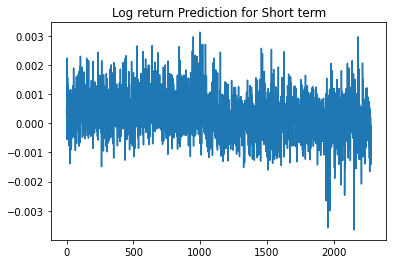

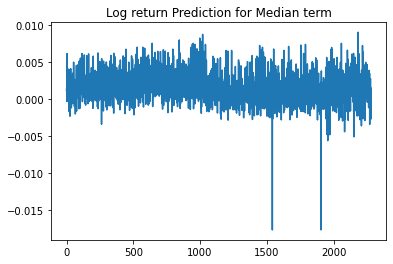

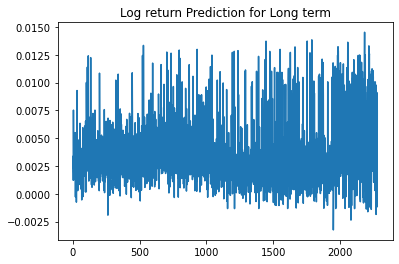

In [22]:
plt.plot(y_pred1)
plt.title('Log return Prediction for Short term')
plt.show()
plt.plot(y_pred2)
plt.title('Log return Prediction for Median term')
plt.show()
plt.plot(y_pred3)
plt.title('Log return Prediction for Long term')
plt.show()

In [23]:
def Result_Analysis(y_real,y_predict):
    bias = np.mean(y_real-y_predict)
    MAE = np.mean(np.abs(y_real-y_predict))
    RMSE = np.sqrt(np.mean((y_real-y_predict)**2))
    y_bar = np.mean(y_real)
    SST = np.sum((y_real- y_bar)**2)
    SSReg = np.sum((y_predict - y_bar)**2)
    R_squared = SSReg/SST
    
    return bias, MAE, RMSE, R_squared

display('bias, MAE, RMSE, R_squared',Result_Analysis(y1_test,y_pred1))
display('bias, MAE, RMSE, R_squared',Result_Analysis(y2_test,y_pred2))
display('bias, MAE, RMSE, R_squared',Result_Analysis(y3_test,y_pred3))

'bias, MAE, RMSE, R_squared'

(0.0003050951601450544,
 0.010580249005214105,
 0.014196580849271697,
 0.0033115813131997444)

'bias, MAE, RMSE, R_squared'

(0.000472520927014668,
 0.0200849600418035,
 0.026577608734913383,
 0.006591342928768266)

'bias, MAE, RMSE, R_squared'

(0.0006527585491002665,
 0.029187694281066538,
 0.03880293503843024,
 0.006354050249995057)

# classification
## LDA

In [160]:
Data['3days_LogReturn1'] = np.where((Data['3days_LogReturn'] >0 ),1,0)
#Data['3days_LogReturn1'] = np.where((Data['3days_LogReturn'] <0 ),0,Data['3days_LogReturn'])

Data['10days_LogReturn1'] = np.where((Data['10days_LogReturn'] >0 ),1,0)
#Data['10days_LogReturn1'] = np.where((Data['10days_LogReturn'] <0 ),0,Data['10days_LogReturn'])

Data['22days_LogReturn1'] = np.where((Data['22days_LogReturn'] >0 ),1,0)
#Data['22days_LogReturn1'] = np.where((Data['22days_LogReturn'] <0 ),0,Data['22days_LogReturn'])

In [161]:
Data.head(20)

,compound,neg,neu,pos,3days_LogReturn,10days_LogReturn,22days_LogReturn,Bag_of_Words,3days_LogReturn1,10days_LogReturn1,22days_LogReturn1
2000-01-03,0.9991,0.268,0.334,0.398,-0.043261,0.010030,0.049174,"[0.9991, 0.268, 0.334, 0.398]",0,1,1
2000-01-04,0.9798,0.247,0.437,0.316,0.020705,0.058900,0.086139,"[0.9798, 0.247, 0.437, 0.316]",1,1,1
2000-01-05,0.9992,0.285,0.342,0.373,0.028868,0.062837,0.078432,"[0.9992, 0.285, 0.342, 0.373]",1,1,1
2000-01-06,0.9982,0.278,0.365,0.357,0.045275,0.071096,0.059261,"[0.9982, 0.278, 0.365, 0.357]",1,1,1
2000-01-07,0.9992,0.274,0.362,0.364,0.026291,0.046054,0.026291,"[0.9992, 0.274, 0.362, 0.364]",1,1,1
2000-01-08,0.987,0.303,0.356,0.341,0.000000,0.041797,0.014127,"[0.987, 0.303, 0.356, 0.341]",0,1,1
2000-01-09,0.9998,0.277,0.35,0.372,-0.014185,0.045239,-0.002014,"[0.9998, 0.277, 0.35, 0.372]",0,1,0
2000-01-10,0.9928,0.257,0.393,0.35,0.000000,0.050594,0.003984,"[0.9928, 0.257, 0.393, 0.35]",0,1,1
2000-01-11,0.9993,0.275,0.358,0.368,0.030032,0.080043,0.033969,"[0.9993, 0.275, 0.358, 0.368]",1,1,1
2000-01-12,0.9995,0.294,0.313,0.393,0.038043,0.078472,0.061345,"[0.9995, 0.294, 0.313, 0.393]",1,1,1


In [260]:
acc_vals=[]
f1_vals=[]
roc_auc_vals=[]

In [263]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
RSEED=100
#x1=Data.loc[:, 'compound':'pos']
x1=Data[ ['compound']]
y = Data['22days_LogReturn1']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                        test_size=0.3,
                                                        random_state = RSEED)

#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)
    
    
LDA = LinearDiscriminantAnalysis()
    

# Fit on training data
LDA.fit(X_train, y_train)
y_pred4=LDA.predict(X_test)    
#Evaluation
#r2_score=LDA.score(X_test, y_test)
#display('bias, MAE, RMSE, R_squared',Result_Analysis(y_test,y_pred4))
#bias_vals.append(Result_Analysis(y_test,y_pred4)[0])
#mae_vals.append(Result_Analysis(y_test,y_pred4)[1])
#rmse_vals.append(Result_Analysis(y_test,y_pred4)[2])
#r2_vals.append(Result_Analysis(y_test,y_pred4)[3])
#accuracy_score(y_test,y_pred4)
acc_vals.append(accuracy_score(y_test,y_pred4))
f1_vals.append(f1_score(y_test,y_pred4))
roc_auc_vals.append(roc_auc_score(y_test,y_pred4))
#print("score",r2_score)

In [265]:
models = ['3_day Lag','10_day Lag', '22_day Lag']
tab = pd.DataFrame({'LDA': models, 'acc':acc_vals,'f1':f1_vals, 'roc_auc': roc_auc_vals})
tab.style.hide_index()

LDA,acc,f1,roc_auc
3_day Lag,0.514652,0.679565,0.500000
10_day Lag,0.529762,0.692607,0.500000
22_day Lag,0.576007,0.730970,0.500000


In [269]:
acc_vals=[]
f1_vals=[]
roc_auc_vals=[]

In [272]:


from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
RSEED=100
#x1=Data.loc[:, 'compound':'pos']
x1=Data.loc[:, 'compound':'pos']
y = Data['22days_LogReturn1']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                        test_size=0.3,
                                                        random_state = RSEED)

#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)
    
    
LDA = LinearDiscriminantAnalysis()
    

# Fit on training data
LDA.fit(X_train, y_train)
y_pred4=LDA.predict(X_test)    
#Evaluation
#r2_score=LDA.score(X_test, y_test)
acc_vals.append(accuracy_score(y_test,y_pred4))
f1_vals.append(f1_score(y_test,y_pred4))
roc_auc_vals.append(roc_auc_score(y_test,y_pred4))
#print("score",r2_score)

In [273]:
models = ['3_day Lag','10_day Lag', '22_day Lag']
tab = pd.DataFrame({'LDA': models, 'acc':acc_vals,'f1':f1_vals, 'roc_auc': roc_auc_vals})
tab.style.hide_index()

LDA,acc,f1,roc_auc
3_day Lag,0.515110,0.674854,0.501143
10_day Lag,0.530678,0.692654,0.501083
22_day Lag,0.576923,0.731395,0.501080


## Random Forest

### HyperTune

In [200]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
#splitting to test and train
x1=Data[ ['compound']]
y = Data['22days_LogReturn1']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                        test_size=0.3,
                                                        random_state = RSEED)

#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)

print("XTrain",X_train.shape)
print("XTest",X_test.shape)

# Create the model with 10 trees
#regressor = RandomForestRegressor(n_estimators = 100,
                                 # random_state = RSEED)

# Fit on training data
#regressor.fit(X_train, y_train)

parameters={'n_estimators':[4, 16,32,50,64,100,128, 256],'max_depth': [2, 8, 16,32,50,64]}
rf = RandomForestClassifier(random_state = RSEED)
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train)
print(clf.best_params_)

XTrain (5096, 1)
XTest (2184, 1)
{'max_depth': 2, 'n_estimators': 16}


In [330]:
acc_vals=[]
f1_vals=[]
roc_auc_vals=[]

In [334]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
RSEED=100
#x1=Data.loc[:, 'compound':'pos']
x1=Data[ ['compound']]
y = Data['22days_LogReturn1']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                        test_size=0.3,
                                                        random_state = RSEED)

#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)
    
clf = RandomForestClassifier(max_depth=2, n_estimators= 16,random_state=0)
clf.fit(X_train, y_train)    

y_pred4=clf.predict(X_test)    
#Evaluation
#r2_score=LDA.score(X_test, y_test)
acc_vals.append(accuracy_score(y_test,y_pred4))
f1_vals.append(f1_score(y_test,y_pred4))
roc_auc_vals.append(roc_auc_score(y_test,y_pred4))
#print("score",r2_score)

In [335]:
models = ['3_day Lag','10_day Lag', '22_day Lag']
tab = pd.DataFrame({'RF': models, 'acc':acc_vals,'f1':f1_vals, 'roc_auc': roc_auc_vals})
tab.style.hide_index()

RF,acc,f1,roc_auc
3_day Lag,0.512821,0.676988,0.498355
10_day Lag,0.529762,0.692423,0.500055
22_day Lag,0.576465,0.731183,0.500540


In [336]:
acc_vals=[]
f1_vals=[]
roc_auc_vals=[]

In [339]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
RSEED=100
x1=Data.loc[:, 'compound':'pos']
#x1=Data[ ['compound']]
y = Data['22days_LogReturn1']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                        test_size=0.3,
                                                        random_state = RSEED)

#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)
    
clf = RandomForestClassifier(max_depth=2, n_estimators= 16,random_state=0)
clf.fit(X_train, y_train)    

y_pred4=clf.predict(X_test)    
#Evaluation
#r2_score=LDA.score(X_test, y_test)
acc_vals.append(accuracy_score(y_test,y_pred4))
f1_vals.append(f1_score(y_test,y_pred4))
roc_auc_vals.append(roc_auc_score(y_test,y_pred4))
#print("score",r2_score)

In [340]:
models = ['3_day Lag','10_day Lag', '22_day Lag']
tab = pd.DataFrame({'RF': models, 'acc':acc_vals,'f1':f1_vals, 'roc_auc': roc_auc_vals})
tab.style.hide_index()

RF,acc,f1,roc_auc
3_day Lag,0.509158,0.672572,0.494957
10_day Lag,0.529762,0.692054,0.500164
22_day Lag,0.576007,0.730657,0.500285


### 3-class Classification

In [289]:
def alert(c):
    if c['3days_LogReturn'] > 0.01:
        return 1
    elif c['3days_LogReturn'] < -0.01:
        return -1
    else:
        return 0

Data['3days_LogReturn11'] = df.apply(alert, axis=1)


def alert(c):
    if c['10days_LogReturn'] > 0.01:
        return 1
    elif c['10days_LogReturn'] < -0.01:
        return -1
    else:
        return 0

Data['10days_LogReturn11'] = df.apply(alert, axis=1)

def alert(c):
    if c['22days_LogReturn'] > 0.01:
        return 1
    elif c['22days_LogReturn'] < -0.01:
        return -1
    else:
        return 0

Data['22days_LogReturn11'] = df.apply(alert, axis=1)

Data.head(50)

,compound,neg,neu,pos,3days_LogReturn,10days_LogReturn,22days_LogReturn,Bag_of_Words,3days_LogReturn1,10days_LogReturn1,22days_LogReturn1,3days_LogReturn11,10days_LogReturn11,22days_LogReturn11
2000-01-03,0.9991,0.268,0.334,0.398,-0.043261,0.010030,0.049174,"[0.9991, 0.268, 0.334, 0.398]",0,1,1,-1,1,1
2000-01-04,0.9798,0.247,0.437,0.316,0.020705,0.058900,0.086139,"[0.9798, 0.247, 0.437, 0.316]",1,1,1,1,1,1
2000-01-05,0.9992,0.285,0.342,0.373,0.028868,0.062837,0.078432,"[0.9992, 0.285, 0.342, 0.373]",1,1,1,1,1,1
2000-01-06,0.9982,0.278,0.365,0.357,0.045275,0.071096,0.059261,"[0.9982, 0.278, 0.365, 0.357]",1,1,1,1,1,1
2000-01-07,0.9992,0.274,0.362,0.364,0.026291,0.046054,0.026291,"[0.9992, 0.274, 0.362, 0.364]",1,1,1,1,1,1
2000-01-08,0.987,0.303,0.356,0.341,0.000000,0.041797,0.014127,"[0.987, 0.303, 0.356, 0.341]",0,1,1,0,1,1
2000-01-09,0.9998,0.277,0.35,0.372,-0.014185,0.045239,-0.002014,"[0.9998, 0.277, 0.35, 0.372]",0,1,0,-1,1,0
2000-01-10,0.9928,0.257,0.393,0.35,0.000000,0.050594,0.003984,"[0.9928, 0.257, 0.393, 0.35]",0,1,1,0,1,0
2000-01-11,0.9993,0.275,0.358,0.368,0.030032,0.080043,0.033969,"[0.9993, 0.275, 0.358, 0.368]",1,1,1,1,1,1
2000-01-12,0.9995,0.294,0.313,0.393,0.038043,0.078472,0.061345,"[0.9995, 0.294, 0.313, 0.393]",1,1,1,1,1,1


# LDA

In [396]:
acc_vals=[]
f1_vals=[]
roc_auc_vals=[]

In [399]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

RSEED=100
#x1=Data.loc[:, 'compound':'pos']
x1=Data[ ['compound']]
y = Data['22days_LogReturn11']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                        test_size=0.3,
                                                        random_state = RSEED)

#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)
    
    
LDA = LinearDiscriminantAnalysis()
    

# Fit on training data
LDA.fit(X_train, y_train)
y_pred4=LDA.predict(X_test)    
#Evaluation
#r2_score=LDA.score(X_test, y_test)
#display('bias, MAE, RMSE, R_squared',Result_Analysis(y_test,y_pred4))
#bias_vals.append(Result_Analysis(y_test,y_pred4)[0])
#mae_vals.append(Result_Analysis(y_test,y_pred4)[1])
#rmse_vals.append(Result_Analysis(y_test,y_pred4)[2])
#r2_vals.append(Result_Analysis(y_test,y_pred4)[3])
#print("score",r2_score)
#accuracy_score(y_test,y_pred4)
acc_vals.append(accuracy_score(y_test,y_pred4))
f1_vals.append(f1_score(y_test,y_pred4,average='macro'))
#roc_auc_vals.append(roc_auc_score(y_test,y_pred4,average='micro',multi_class='ovr'))

In [400]:
models = ['3_day Lag','10_day Lag', '22_day Lag']
tab = pd.DataFrame({'LDA': models, 'acc':acc_vals,'f1_macro':f1_vals})
tab.style.hide_index()

LDA,acc,f1_macro
3_day Lag,0.499084,0.221951
10_day Lag,0.404762,0.192090
22_day Lag,0.494963,0.220725


In [418]:
acc_vals=[]
f1_vals=[]
roc_auc_vals=[]

In [421]:


from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
RSEED=100
#x1=Data.loc[:, 'compound':'pos']
x1=Data.loc[:, 'compound':'pos']
y = Data['22days_LogReturn11']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                        test_size=0.3,
                                                        random_state = RSEED)

#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)
    
    
LDA = LinearDiscriminantAnalysis()
    

# Fit on training data
LDA.fit(X_train, y_train)
y_pred4=LDA.predict(X_test)    
#Evaluation
#r2_score=LDA.score(X_test, y_test)
acc_vals.append(accuracy_score(y_test,y_pred4))
f1_vals.append(f1_score(y_test,y_pred4,average='macro'))
#print("score",r2_score)

In [422]:
models = ['3_day Lag','10_day Lag', '22_day Lag']
tab = pd.DataFrame({'LDA': models, 'acc':acc_vals,'f1_macro':f1_vals})
tab.style.hide_index()

LDA,acc,f1_macro
3_day Lag,0.497711,0.225072
10_day Lag,0.405678,0.194140
22_day Lag,0.495421,0.222707


## Random Forest

### HyperTune

In [218]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
#splitting to test and train
x1=Data[ ['compound']]
y = Data['22days_LogReturn11']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                    test_size=0.3,
                                                    random_state = RSEED)
#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)

print("XTrain",X_train.shape)
print("XTest",X_test.shape)

# Create the model with 10 trees
#regressor = RandomForestRegressor(n_estimators = 100,
                                 # random_state = RSEED)

# Fit on training data
#regressor.fit(X_train, y_train)

parameters={'n_estimators':[4, 16,32,50,64,100,128, 256],'max_depth': [2, 8, 16,32,50,64]}
rf = RandomForestClassifier(random_state = RSEED)
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train)
print(clf.best_params_)

XTrain (5096, 1)
XTest (2184, 1)
{'max_depth': 2, 'n_estimators': 16}


In [408]:
acc_vals=[]
f1_vals=[]
roc_auc_vals=[]

In [411]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
RSEED=100
#x1=Data.loc[:, 'compound':'pos']
x1=Data[ ['compound']]
y = Data['22days_LogReturn11']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                        test_size=0.3,
                                                        random_state = RSEED)

#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)
    
clf = RandomForestClassifier(max_depth=2, n_estimators= 16,random_state=0)
clf.fit(X_train, y_train)    

y_pred4=clf.predict(X_test)    
#Evaluation
#r2_score=LDA.score(X_test, y_test)
acc_vals.append(accuracy_score(y_test,y_pred4))
f1_vals.append(f1_score(y_test,y_pred4,average='macro'))
#print("score",r2_score)

In [412]:
models = ['3_day Lag','10_day Lag', '22_day Lag']
tab = pd.DataFrame({'RF': models, 'acc':acc_vals,'f1_macro':f1_vals})
tab.style.hide_index()

RF,acc,f1_macro
3_day Lag,0.499084,0.221951
10_day Lag,0.404762,0.192090
22_day Lag,0.494963,0.220725


In [413]:
acc_vals=[]
f1_vals=[]
roc_auc_vals=[]

In [416]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
RSEED=100
x1=Data.loc[:, 'compound':'pos']
#x1=Data[ ['compound']]
y = Data['22days_LogReturn11']

X_train, X_test, y_train, y_test = train_test_split(x1, y,
                                                        test_size=0.3,
                                                        random_state = RSEED)

#scaler = StandardScaler()
#scaler.fit(X_train1)

#X_train = scaler.transform(X_train1)
#X_test = scaler.transform(X_test1)
    
clf = RandomForestClassifier(max_depth=2, n_estimators= 16,random_state=0)
clf.fit(X_train, y_train)    

y_pred4=clf.predict(X_test)    
#Evaluation
#r2_score=LDA.score(X_test, y_test)

acc_vals.append(accuracy_score(y_test,y_pred4))
f1_vals.append(f1_score(y_test,y_pred4,average='macro'))
#print("score",r2_score)

In [417]:
models = ['3_day Lag','10_day Lag', '22_day Lag']
tab = pd.DataFrame({'RF': models, 'acc':acc_vals,'f1_macro':f1_vals})
tab.style.hide_index()

RF,acc,f1_macro
3_day Lag,0.499084,0.221951
10_day Lag,0.403846,0.192709
22_day Lag,0.494963,0.220725
